In [1]:
import json
import os
import types
import zipfile

import numpy
import pandas
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models

2024-03-24 11:21:49.489804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 11:21:49.538298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:21:49.663236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:21:49.663810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 11:21:50.304335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [31]:
data_folder = 'data_nordic/'

segments, labels = [], []
one_hot_encoding = {}

for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        try:
            file_data = pandas.read_csv(os.path.join(data_folder, filename))

            for _, row in file_data.iterrows():
                segment_data = row[['X', 'Y', 'Z']].values
                label = row['Label']

                if label not in one_hot_encoding:
                    one_hot_encoding[label] = len(one_hot_encoding)

                segments.append(segment_data)
                labels.append(one_hot_encoding[label])

        except FileNotFoundError:
            pass

max_length = min(len(segment) for segment in segments)
x = numpy.array([segment[:max_length] for segment in segments]) / 1000
y = tf.keras.utils.to_categorical(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, stratify=y)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train - numpy.mean(x_train)) / numpy.std(x_train)
x_test = (x_test - numpy.mean(x_test)) / numpy.std(x_test)

In [3]:
x.shape

(13405, 3)

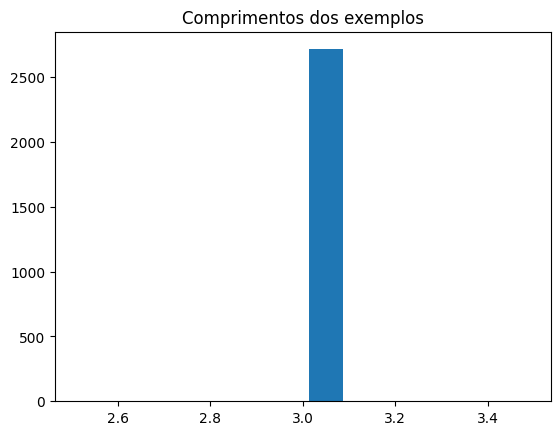

In [11]:
pyplot.title('Comprimentos dos exemplos')
lengths = numpy.array([len(segment) for segment in segments])
pyplot.hist(lengths, rwidth=0.75, bins=10)

pyplot.show()

['Z', 'V'] [3278 3352]
['Z', 'V'] [579 591]


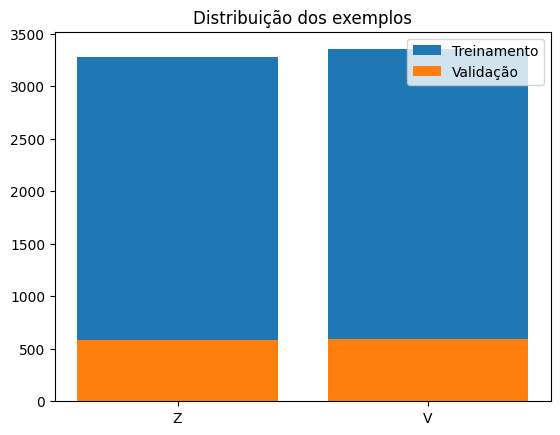

In [32]:
labels = list(one_hot_encoding.keys())

pyplot.title('Distribuição dos exemplos')

height =  numpy.histogram(y_train.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Treinamento')

height =  numpy.histogram(y_test.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Validação')

pyplot.legend()
pyplot.show()

In [33]:
# Adicionando uma dimensão extra para os canais
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Defina a arquitetura da rede neural
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(one_hot_encoding), activation='softmax')
])

# Compile o modelo")

model.compile(loss='categorical_crossentropy',
              metrics=['acc'])

# Treine o modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
208/208 [==============================] - 0s 1ms/step - loss: 0.6421 - acc: 0.6192 - val_loss: 0.5974 - val_acc: 0.6906
Epoch 2/100
208/208 [==============================] - 0s 1ms/step - loss: 0.5605 - acc: 0.7154 - val_loss: 0.5362 - val_acc: 0.7427
Epoch 3/100
208/208 [==============================] - 0s 918us/step - loss: 0.5062 - acc: 0.7742 - val_loss: 0.4935 - val_acc: 0.7872
Epoch 4/100
208/208 [==============================] - 0s 896us/step - loss: 0.4706 - acc: 0.7922 - val_loss: 0.4683 - val_acc: 0.7906
Epoch 5/100
208/208 [==============================] - 0s 941us/step - loss: 0.4483 - acc: 0.7989 - val_loss: 0.4504 - val_acc: 0.7932
Epoch 6/100
208/208 [==============================] - 0s 962us/step - loss: 0.4334 - acc: 0.8063 - val_loss: 0.4402 - val_acc: 0.7829
Epoch 7/100
208/208 [==============================] - 0s 953us/step - loss: 0.4238 - acc: 0.8027 - val_loss: 0.4313 - val_acc: 0.8094
Epoch 8/100
208/208 [==============================] - 0s 9

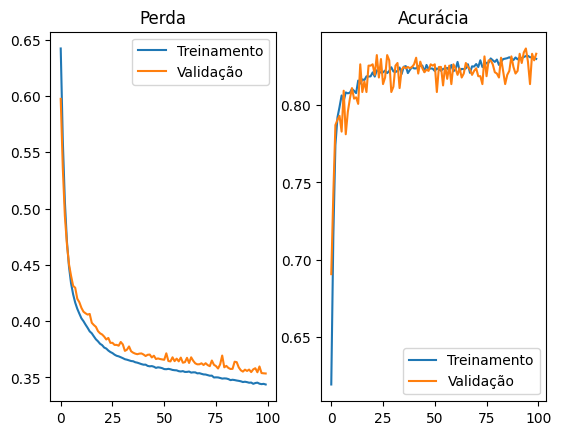

In [34]:
fig, ax = pyplot.subplots(1, 2)

ax[0].set_title('Perda')
ax[0].plot(history.epoch, history.history['loss'], label='Treinamento')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validação')
ax[0].legend()

ax[1].set_title('Acurácia')
ax[1].plot(history.epoch, history.history['acc'], label='Treinamento')
ax[1].plot(history.epoch, history.history['val_acc'], label='Validação')
ax[1].legend()

pyplot.show()

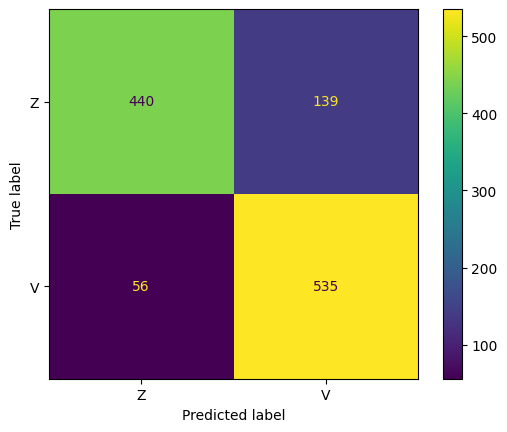

,Z,V,accuracy,macro avg,weighted avg
precision,0.887097,0.793769,0.833333,0.840433,0.839954
recall,0.759931,0.905245,0.833333,0.832588,0.833333
f1-score,0.818605,0.845850,0.833333,0.832227,0.832367
support,579.000000,591.000000,0.833333,1170.000000,1170.000000


In [35]:
y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
y_true = y_test.argmax(axis=1)

labels = list(one_hot_encoding.keys())
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=labels)
pyplot.show()

pandas.DataFrame.from_dict(classification_report(y_true, y_pred, target_names=labels, output_dict=True))

In [23]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
            numpy.product(list(map(int, v.shape))) * v.dtype.size
            for v in model.trainable_variables
    ]
    print("Model size:", sum(var_sizes) / 1024, "KB")


calculate_model_size(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 32)             128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 227 (908.00 Byte)
Trainable params: 227 (908.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model size: 0.88671875 KB


In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmp6tlae8j5/assets


INFO:tensorflow:Assets written to: /tmp/tmp6tlae8j5/assets
2024-03-24 11:47:03.672722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-24 11:47:03.672743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-24 11:47:03.672866: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6tlae8j5
2024-03-24 11:47:03.673312: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-24 11:47:03.673320: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp6tlae8j5
2024-03-24 11:47:03.674547: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-24 11:47:03.691862: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp6tlae8j5
2024-03-24 11:47:03.698018: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprztgmkoy/assets


INFO:tensorflow:Assets written to: /tmp/tmprztgmkoy/assets
2024-03-24 11:47:04.089883: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-24 11:47:04.089908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-24 11:47:04.090053: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprztgmkoy
2024-03-24 11:47:04.090548: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-24 11:47:04.090558: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmprztgmkoy
2024-03-24 11:47:04.091920: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-24 11:47:04.112017: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmprztgmkoy
2024-03-24 11:47:04.120033: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Basic model is 4248 bytes
Quantized model is 4252 bytes
Difference is -4 bytes
